# CNN model

In [1]:
import zipfile
import os

zip_file_path_lst = ['Z.zip','S.zip','F.zip','N.zip','O.zip']
extracted_folder_path = 'extracted_data'

for zip_file_path in zip_file_path_lst:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)

# 1. Data loading and preparation:
1.1 data from text files are loaded, converted into a format suitable for use with PyTorch

In [2]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_list = []

label_lst = ['Z','S','F','N','O'] # List of labels for each class
int_label = [0,1,2,3,4] # Create corresponding integer labels for each class

for i,label in enumerate(label_lst):

    folder_path = os.path.join('extracted_data',label)

    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        
        # Load data from text file
        with open(file_path, 'r') as file:
            data = [int(value) for value in file.read().split()]
            data.append(int_label[i])
            data_list.append(data)

# Convert the list of lists to a numpy array
np_data = np.array(data_list)

# Convert the numpy array to a PyTorch tensor
torch_data = torch.tensor(np_data)

# Print the shape of the resulting tensor
print(torch_data.shape)

torch.Size([500, 4098])


1.2 define a dataset class for EEG data, tailored for use with PyTorch's data handling and batching utilities

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class EEGDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx, :-1]  # Exclude the last column (label)
        label = self.data[idx, -1]  # Extract the label
        if self.transform:
            sample = self.transform(sample)
        return sample.unsqueeze(0), label.long()

1.3 Data spliting & normalization: 

takes a PyTorch tensor containing EEG data, splits it into training, testing, and validation sets, normalizes the features, and then prepares DataLoader instances for each set. 

In [4]:

train_data, test_data = train_test_split(torch_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_data = train_data.float().to(device)
test_data = test_data.float().to(device)
val_data = val_data.float().to(device)

def normalize_data(data_tensor):
    # Convert the tensor to float
    data_tensor = data_tensor.float()

    # Calculate mean and standard deviation along each column
    mean = torch.mean(data_tensor, dim=0)
    std = torch.std(data_tensor, dim=0)

    # Apply normalization
    normalized_data = (data_tensor - mean) / std

    return normalized_data

train_data[:,:-1] = normalize_data(train_data[:,:-1])
test_data[:,:-1] = normalize_data(test_data[:,:-1])
val_data[:,:-1] = normalize_data(val_data[:,:-1])

# Create instances of EEGDataset for training, testing, and validation
train_dataset = EEGDataset(train_data)
test_dataset = EEGDataset(test_data)
val_dataset = EEGDataset(val_data)

# Create DataLoader instances for training, testing, and validation
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(train_data[0,:])

tensor([-1.4471, -0.4751,  0.6550,  ..., -2.1578,  0.7448,  1.0000],
       device='cuda:0')


# 2. Construct the CNN model

#2.1 Build neural network that is suitable for this 1-dimensional EEG input data

with 3 convolutional layers followed by 2 fully connected layers, incorporating elements: ReLU activation, batch normalization, and dropout.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalCNN(nn.Module):
    def __init__(self, input_size, num_classes, c1, c2, c3, dropout_rate=0.5):
        super(HierarchicalCNN, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c1, kernel_size=16, stride=4, padding=0)
        self.batch_norm1 = nn.BatchNorm1d(c1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        # Second convolution block
        self.conv2 = nn.Conv1d(in_channels=c1, out_channels=c2, kernel_size=8, stride=2, padding=0)
        self.batch_norm2 = nn.BatchNorm1d(c2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Third convolution block
        self.conv3 = nn.Conv1d(in_channels=c2, out_channels=c3, kernel_size=4, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm1d(c3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(c3 * 504, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):   #defines how the data flows through the network
        # First convolution block
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second convolution block
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Third convolution block
        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

#2.2 training, validating, and testing CNN model

In [7]:
import torch.optim as optim

input_size = 4097
num_classes = 5

# Function to train the model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to evaluate the model
def evaluate(model, eval_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return running_loss / len(eval_loader), accuracy

# Function to test the model
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

#2.3 Tune the channel parameters of CNN model

explores different configurations (2,4,8), trains the model for each, and identifies the configuration that leads to the highest accuracy on the validation set.

In [17]:
from itertools import product

def create_hashing_lists(input_list):
    # Use itertools.product to generate all combinations
    hashing_lists = list(product(input_list, repeat=len(input_list)))
    return hashing_lists

input_list = [2, 4, 8]
hashing_lists = create_hashing_lists(input_list)

In [18]:
test_accuracy_list = np.zeros(len(hashing_lists))
for ind, hashing_list in enumerate(hashing_lists):
    c1, c2, c3 = hashing_list

    # Define  model, dataloaders, optimizer, and criterion
    model = HierarchicalCNN(input_size, num_classes, c1, c2, c3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()

    # Move model and criterion to the appropriate device (GPU or CPU)
    model.to(device)
    criterion.to(device)

    # Training loop
    best_accuracy = 0.0
    best_model_state_dict = None

    num_epochs = 500  # Set the number of epochs
    for epoch in range(num_epochs):
        # Train the model
        train_loss = train(model, train_loader, optimizer, criterion, device)

        # Evaluate the model
        eval_loss, eval_accuracy = evaluate(model, val_loader, criterion, device)

        # Save the best model based on evaluation accuracy
        if eval_accuracy > best_accuracy:
            best_accuracy = eval_accuracy
            best_model_state_dict = model.state_dict()

    # Load the best model
    model.load_state_dict(best_model_state_dict)
    # Save the best model with the channel combination as the filename
    torch.save(best_model_state_dict, f'model_{c1}_{c2}_{c3}.pth')

    # Test the best model
    test_accuracy = test(model, test_loader, device)
    test_accuracy_list[i] = test_accuracy
    print(f"Test Accuracy of the Best Model with {c1,c2,c3} channels: {test_accuracy:.4f}")

    

Test Accuracy of the Best Model with (2, 2, 2) channels: 0.7200
Test Accuracy of the Best Model with (2, 2, 4) channels: 0.6600
Test Accuracy of the Best Model with (2, 2, 8) channels: 0.6400
Test Accuracy of the Best Model with (2, 4, 2) channels: 0.6800
Test Accuracy of the Best Model with (2, 4, 4) channels: 0.5100
Test Accuracy of the Best Model with (2, 4, 8) channels: 0.7000
Test Accuracy of the Best Model with (2, 8, 2) channels: 0.7300
Test Accuracy of the Best Model with (2, 8, 4) channels: 0.6600
Test Accuracy of the Best Model with (2, 8, 8) channels: 0.6100
Test Accuracy of the Best Model with (4, 2, 2) channels: 0.6200
Test Accuracy of the Best Model with (4, 2, 4) channels: 0.6500
Test Accuracy of the Best Model with (4, 2, 8) channels: 0.7000
Test Accuracy of the Best Model with (4, 4, 2) channels: 0.6300
Test Accuracy of the Best Model with (4, 4, 4) channels: 0.5800
Test Accuracy of the Best Model with (4, 4, 8) channels: 0.6700
Test Accuracy of the Best Model with (4,

# 3. Model Evaluation

#3.1 Load the best model with the highest test accuracy

evaluating several trained models with different hyperparameters on a test dataset, keeping track of the model that achieves the highest number of correct predictions.

In [8]:

from copy import deepcopy


best_correct = 0

for ind, hashing_list in enumerate(hashing_lists):
    c1,c2,c3 = hashing_list
    model = HierarchicalCNN(input_size, num_classes, c1, c2, c3).to(device)
    model.load_state_dict(torch.load(f'model_{c1}_{c2}_{c3}.pth'))

    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        if correct > best_correct:
            best_correct = correct
            best_model = deepcopy(model)
            best_c1 = c1
            best_c2 = c2
            best_c3 = c3
            best_predicted = predicted

In [9]:
print(f'The best-performing model has {best_c1}, {best_c2}, and {best_c3} channels in the three convolutional layers.\n')
print(best_predicted) # print the predictions made by the best-performing model
print(labels)  # print the actual labels
print(f'\nThe number of correct predictions made by the best-performing model is {best_correct}.') 


The best-performing model has 4, 2, and 4 channels in the three convolutional layers.

tensor([3, 0, 3, 1, 1, 3, 3, 1, 0, 0, 4, 1, 1, 3, 3, 3, 0, 3, 3, 4, 4, 4, 2, 3,
        4, 4, 4, 2, 1, 3, 4, 3, 4, 1, 0, 3, 4, 3, 2, 4, 4, 4, 4, 1, 4, 4, 3, 3,
        4, 4, 3, 1, 1, 4, 1, 0, 1, 0, 2, 0, 4, 2, 0, 4, 0, 0, 0, 0, 2, 3, 3, 0,
        2, 2, 2, 1, 2, 2, 4, 4, 1, 3, 4, 1, 3, 0, 1, 4, 2, 2, 2, 4, 3, 3, 4, 3,
        0, 0, 4, 0], device='cuda:0')
tensor([3, 0, 3, 1, 1, 3, 3, 1, 0, 4, 0, 1, 4, 0, 3, 3, 4, 0, 3, 4, 4, 4, 2, 3,
        0, 4, 4, 2, 1, 3, 4, 3, 4, 1, 0, 3, 4, 0, 2, 0, 3, 0, 4, 1, 0, 0, 0, 0,
        4, 0, 0, 1, 1, 4, 1, 0, 1, 0, 2, 0, 4, 2, 3, 4, 0, 0, 4, 0, 2, 3, 3, 3,
        2, 2, 3, 3, 2, 0, 4, 4, 1, 0, 4, 1, 3, 0, 1, 4, 3, 2, 3, 4, 3, 3, 4, 3,
        0, 0, 4, 0], device='cuda:0')

The number of correct predictions made by the best-performing model is 74.


#converting the prediction results and labels from PyTorch tensor format to NumPy array format. This conversion is done for subsequent visualization of the results, as NumPy arrays are a more flexible format for visualization.

In [10]:
best_predicted_array = best_predicted.cpu().numpy()
labels_array = labels.cpu().numpy()

# 4. Visualization

#4.1 generate a confusion matrix

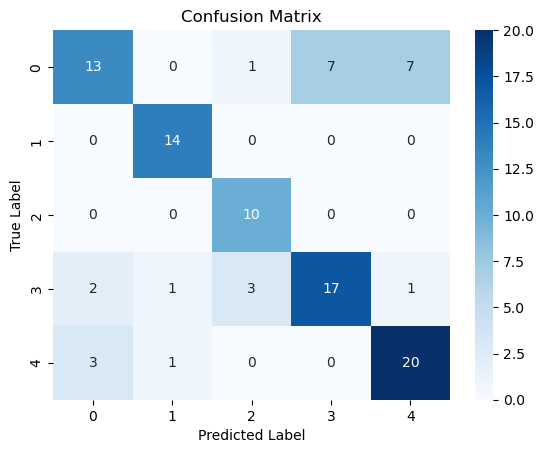

In [11]:
# Use best_predicted_array and labels_array to create a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_array, best_predicted_array)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


#4.2 generate a classification report

In [12]:
# Use best_predicted_array and labels_array to create a classification report   
from sklearn.metrics import classification_report
target_names = ['Z', 'S', 'F', 'N', 'O']
print(classification_report(labels_array, best_predicted_array, target_names=target_names))

              precision    recall  f1-score   support

           Z       0.72      0.46      0.57        28
           S       0.88      1.00      0.93        14
           F       0.71      1.00      0.83        10
           N       0.71      0.71      0.71        24
           O       0.71      0.83      0.77        24

    accuracy                           0.74       100
   macro avg       0.75      0.80      0.76       100
weighted avg       0.74      0.74      0.73       100



**5. CNN Model:**

5.1 **Architecture:**  
   - Constructed a hierarchical CNN model with the following convolutional blocks:

     **5.1.1 First Convolution Block:**  
       - Convolutional Layer 1:  
         - Kernel Size: 16  
         - Stride: 4  
         - Number of Channels: `c1`  
       - Batch Normalization  
       - Dropout with Probability: `dropout_rate`

     **5.1.2 Second Convolution Block:**  
       - Convolutional Layer 2:  
         - Kernel Size: 8  
         - Stride: 2  
         - Number of Channels: `c2`  
       - Batch Normalization  
       - Dropout with Probability: `dropout_rate`

     **5.1.3 Third Convolution Block:**  
       - Convolutional Layer 3:  
         - Kernel Size: 4  
         - Stride: 1  
         - Number of Channels: `c3`  
       - Batch Normalization  
       - Dropout with Probability: `dropout_rate`

   - Fully Connected Layers:  (Include details if any)

5.2 **Training, Validation, and Testing:**  
   - Trained the model using the training set, validated using the validation set, and tested on the test set.
   - Utilized Adam optimizer and CrossEntropyLoss criterion for training.

5.3 **Hyperparameter Tuning:**  
   - Explored different channel configurations for the convolutional layers.
   - Trained models with various configurations and identified the one yielding the highest accuracy on the validation set.
